In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Download MNIST dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("ylecun/mnist")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [3]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


In [4]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Extract a random set of 1000 images (100 from each class 0-9).

In [5]:
# Create an empty list to store the selected images
images = []

# Iterate through the classes (0-9)
for label in range(10):
  images_with_label = [item for item in dataset['train'] if item['label'] == label]

  # Select 100 images randomly from the current label
  random_images = random.sample(images_with_label, 100)

  # Add the selected random images to the list
  images.extend(random_images)

Run PCA algorithm on `images` dataset.

## **PCA**

Perform PCA using top 10 Principal Components.

In [7]:
# Convert each image into numpy array and append it to a list
image_data = [np.array(item['image']) for item in images]

# Stack the NumPy arrays into a single array
X = np.stack(image_data, axis=0)

# Flatten the images
X = X.reshape(X.shape[0], -1)

# 1. Calculate the mean of the data
mean_X = np.mean(X, axis=0)

# 2. Center the data by subtracting the mean
centered_X = X - mean_X

# 3. Calculate the covariance matrix
cov_matrix = np.cov(centered_X, rowvar=False)

# 4. Calculate the eigenvectors and eigenvalues of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# 5. Sort the eigenvectors by decreasing eigenvalues
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvectors = eigenvectors[:, sorted_indices]

# 6. Select the top k eigenvectors (principal components)
k = 10
principal_components = eigenvectors[:, :k]

# 7. Project the centered data onto the principal components
projected_data = np.dot(centered_X, principal_components)

### Visualize the images of the principal components.

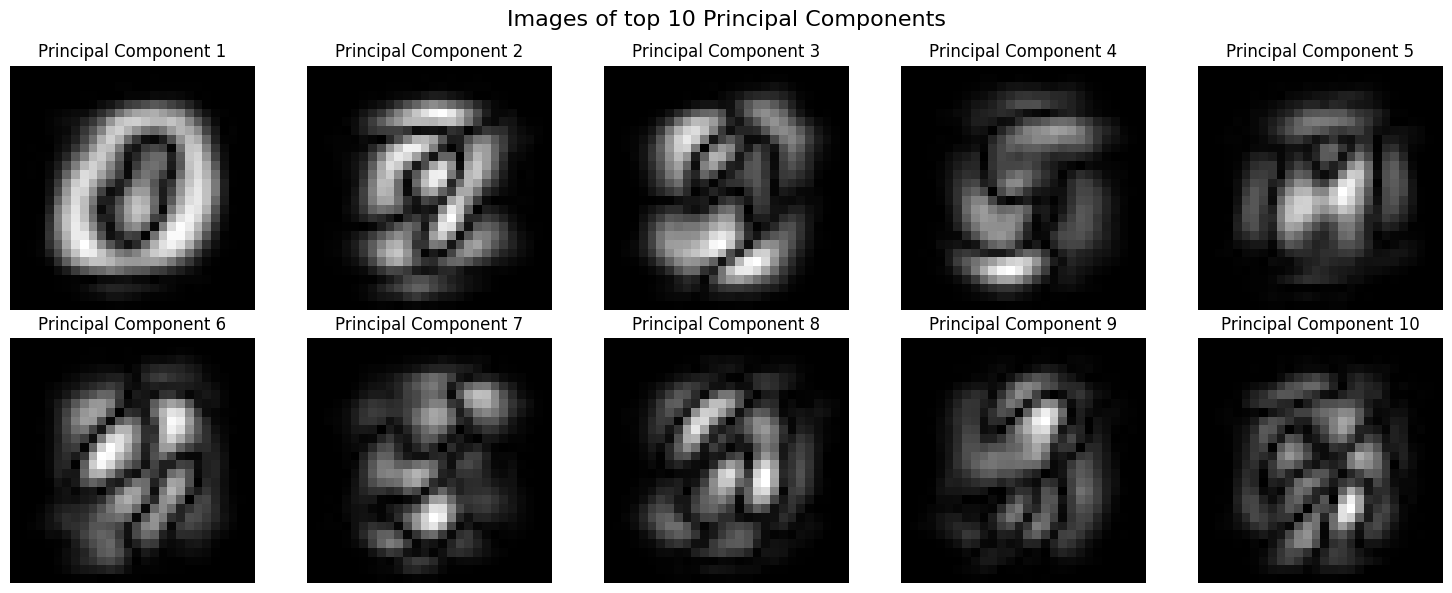

In [8]:
# Reshape the principal components back to image dimensions
n_components = principal_components.shape[1]
img_height, img_width = 28, 28

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
plt.suptitle('Images of top 10 Principal Components', fontsize=16)

for i in range(n_components):
  # Reshape the eigenvector
  eigenvector_image = principal_components[:, i].reshape(img_height, img_width)
  eigenvector_image = np.abs(eigenvector_image)

  ax = axes[i // 5, i % 5]

  # Plot the image
  ax.imshow(eigenvector_image, cmap='gray')
  ax.set_title(f'Principal Component {i+1}')
  ax.axis('off')

plt.tight_layout()
plt.show()

###  Compute the variance in the dataset that has been explained by each of the principal components.

In [9]:
explained_variance_ratio = np.real(eigenvalues) / np.sum(np.real(eigenvalues))

for i in range(k):
  print(f"Principal Component {i+1}: {explained_variance_ratio[sorted_indices][i]:.2%} of the variance")

Principal Component 1: 9.67% of the variance
Principal Component 2: 7.24% of the variance
Principal Component 3: 6.47% of the variance
Principal Component 4: 5.34% of the variance
Principal Component 5: 4.78% of the variance
Principal Component 6: 4.44% of the variance
Principal Component 7: 3.34% of the variance
Principal Component 8: 2.96% of the variance
Principal Component 9: 2.80% of the variance
Principal Component 10: 2.38% of the variance


# **(ii)**

### Reconstruct the dataset using different dimensional representations and visualize few reconstructed images.

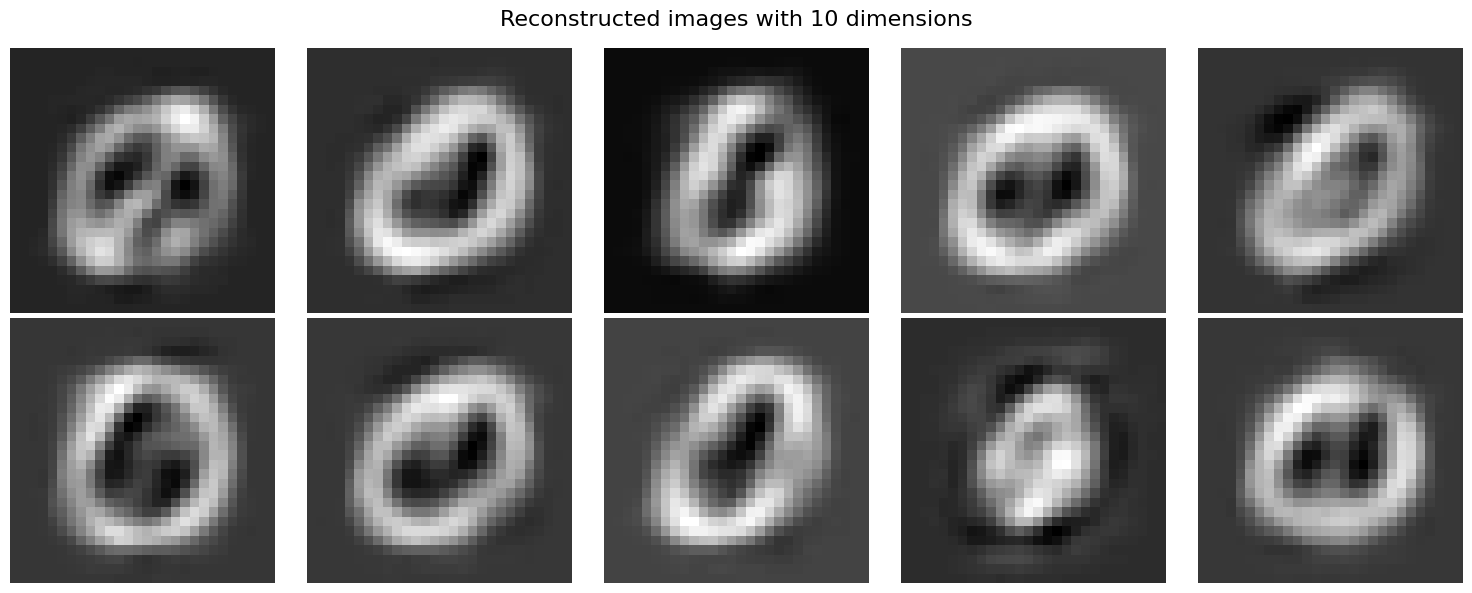

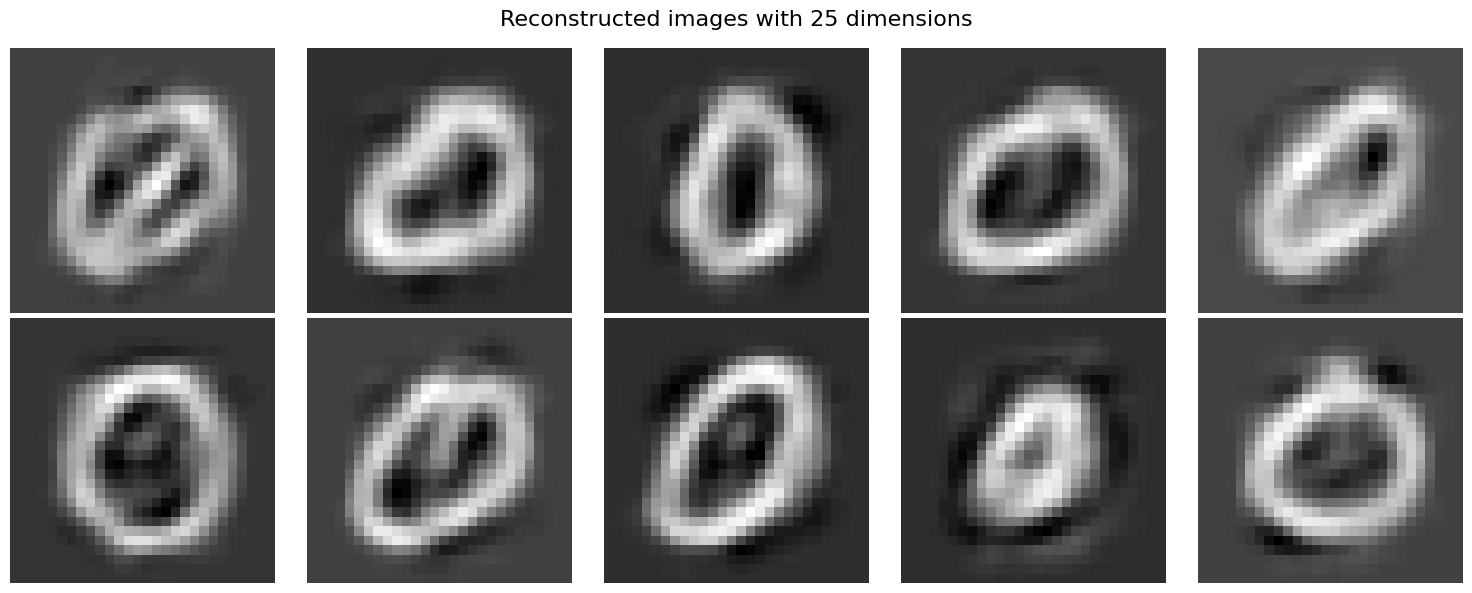

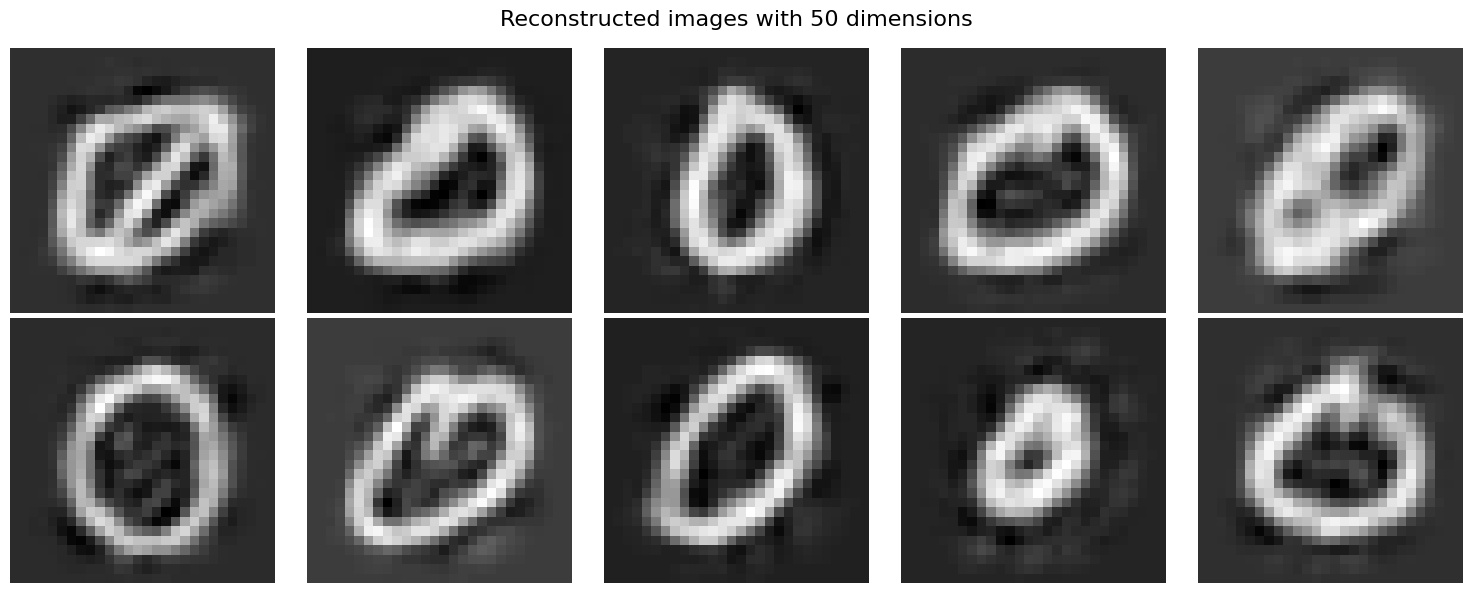

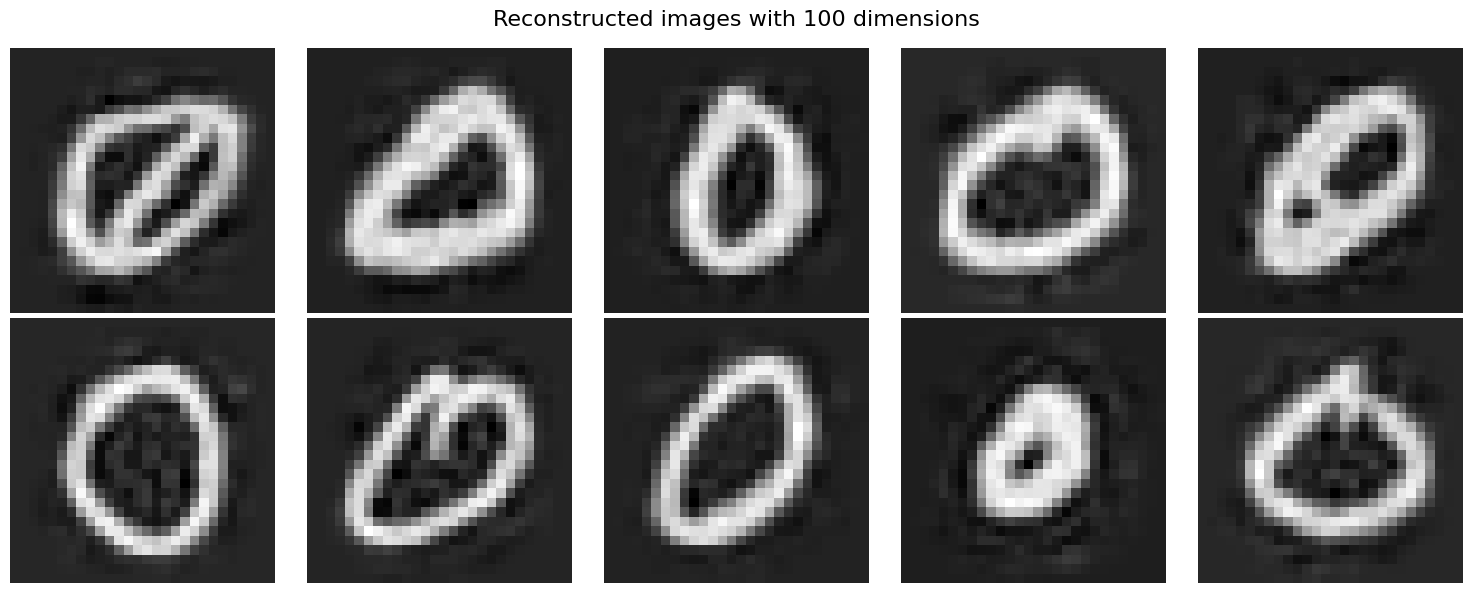

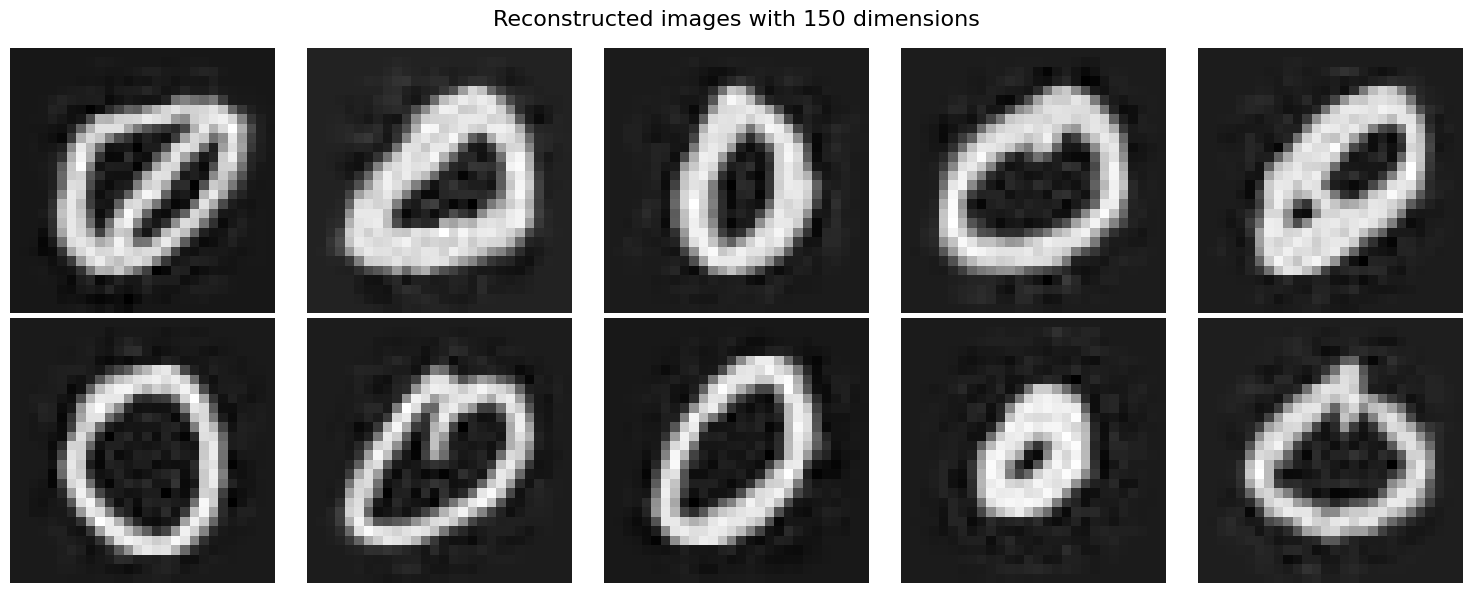

In [10]:
def reconstruct_image(projected_data, principal_components, mean_X, img_height, img_width):
  reconstructed_data = np.dot(projected_data, principal_components.T) + mean_X
  reconstructed_image = np.real(reconstructed_data).reshape(img_height, img_width)
  return reconstructed_image

reconstruct_dimensions = [10, 25, 50, 100, 150]

for n_dimensions in reconstruct_dimensions:
  # Select the top `n_dimensions` principal components
  pc_subset = eigenvectors[:, :n_dimensions]

  # Project the data onto the subset of principal components
  projected_data_subset = np.dot(centered_X, pc_subset)

  # Reconstruct the images using the reduced-dimensional data
  reconstructed_images = [
      reconstruct_image(
          projected_data_subset[i],
          pc_subset,
          mean_X,
          img_height,
          img_width
      )
      for i in range(len(images))
  ]

  # Visualize a few reconstructed images
  fig, axes = plt.subplots(2, 5, figsize=(15, 6))
  plt.suptitle(f'Reconstructed images with {n_dimensions} dimensions', fontsize=16)
  for i in range(10):
      ax = axes[i // 5, i % 5]
      ax.imshow(reconstructed_images[i], cmap='gray')
      ax.axis('off')
  plt.tight_layout()
  plt.show()

### Compute the cumulative variance explained by the principal components and plot the graph.

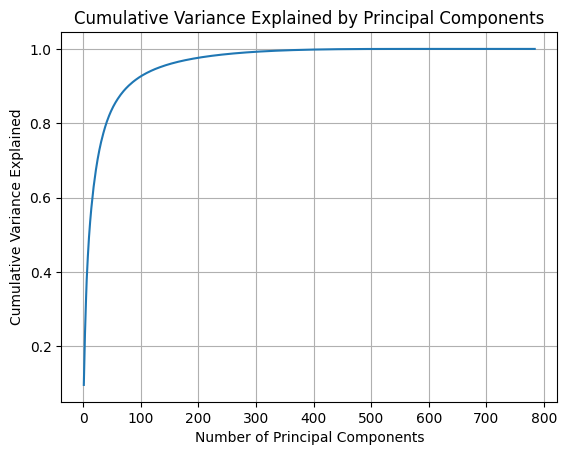

In [11]:
cumulative_variance_explained = np.cumsum(explained_variance_ratio[sorted_indices])

# Plot the cumulative variance explained
plt.plot(range(1, len(cumulative_variance_explained) + 1), cumulative_variance_explained)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
plt.grid(True)
plt.show()

### Compute the cumulative variance explained by the principal components for different values of the number of components.

In [12]:
for n_components in [10, 25, 50, 100, 150]:
  print(f"Cumulative variance explained by {n_components} components: {cumulative_variance_explained[n_components - 1]:.2%}")

Cumulative variance explained by 10 components: 49.42%
Cumulative variance explained by 25 components: 70.37%
Cumulative variance explained by 50 components: 83.85%
Cumulative variance explained by 100 components: 92.64%
Cumulative variance explained by 150 components: 95.94%


### I would pick a dimension of around 50-100 for the downstream task. This is because we observe that around 50-100 principal components capture a significant portion (likely >90%) of the total variance in the dataset. This means that these components retain most of the important information for representing the images, striking a balance between information retention and computational efficiency.
